In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [2]:
df = pd.read_csv("train.csv")
print(f"Shape: {df.shape}")
print(f"Missing Values: {df.isnull().sum().sort_values(ascending=False).head(5)}")
print(f"SalesPrice: {df['SalePrice'].describe()}")

Shape: (1460, 81)
Missing Values: PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
MasVnrType      872
dtype: int64
SalesPrice: count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [3]:
df.shape[1]

81

In [4]:
# Numeric columns (int and float types)
numerical_cols = list(df.select_dtypes(include=['number']).columns)
print(len(numerical_cols), "\n", numerical_cols)

# Categorical Columns (Object or Catagory types)
categorical_cols = list(df.select_dtypes(include=['object', 'category']).columns)
print(len(categorical_cols), "\n", categorical_cols)

38 
 ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
43 
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFini

In [5]:
df.shape

(1460, 81)

In [6]:
missingvalues = df.isnull().sum()
missingvalues[missingvalues > 0].sort_values(ascending=False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

In [7]:
df.shape

(1460, 81)

In [8]:
numerical_cols = df.select_dtypes(['int64', 'float64'])

In [9]:
correlation_matrix = numerical_cols.corr()

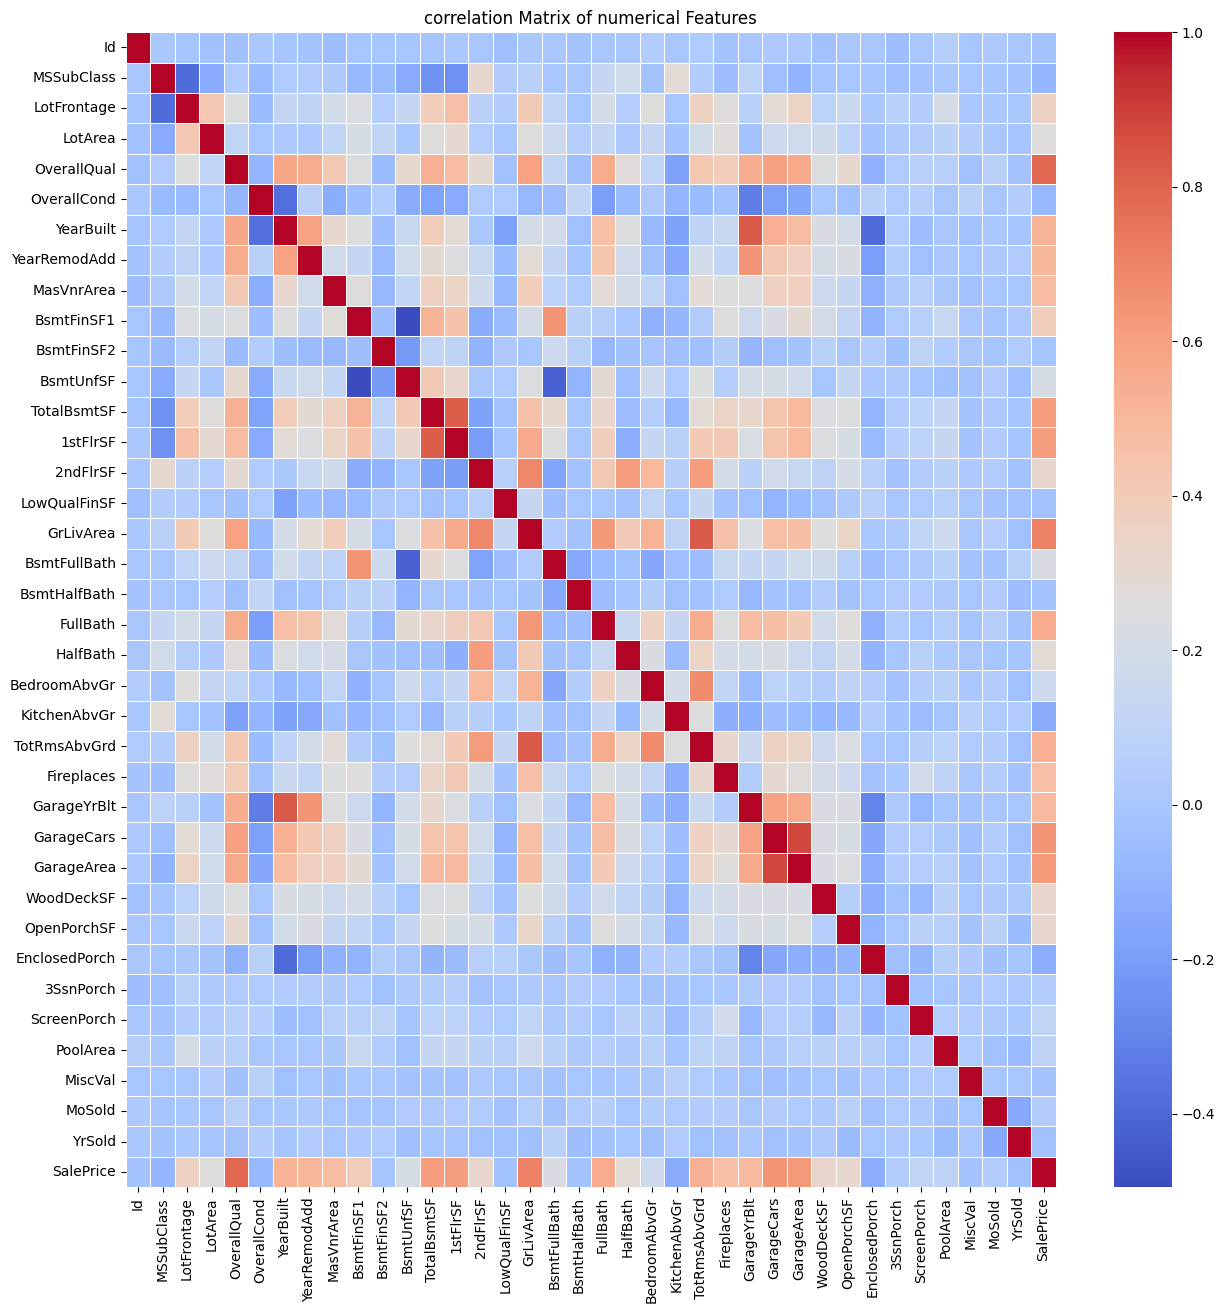

In [10]:
plt.figure(figsize=(15,15))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("correlation Matrix of numerical Features")
plt.show()

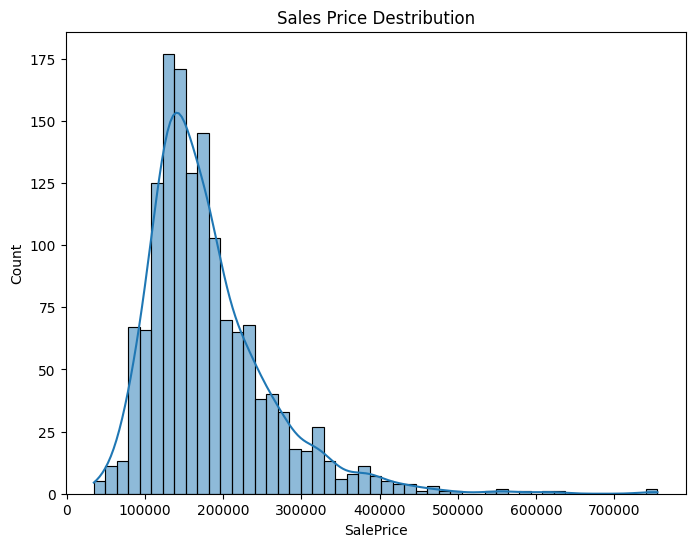

In [11]:
plt.figure(figsize=(8, 6))
sns.histplot(df['SalePrice'], kde=True)
plt.title("Sales Price Destribution")
plt.show()

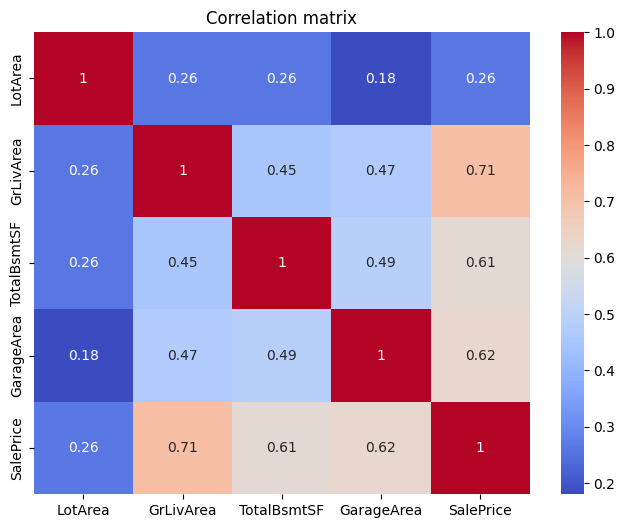

In [12]:
num_cols = ['LotArea', 'GrLivArea', 'TotalBsmtSF', 'GarageArea', 'SalePrice']
corr = df[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation matrix")
plt.show()

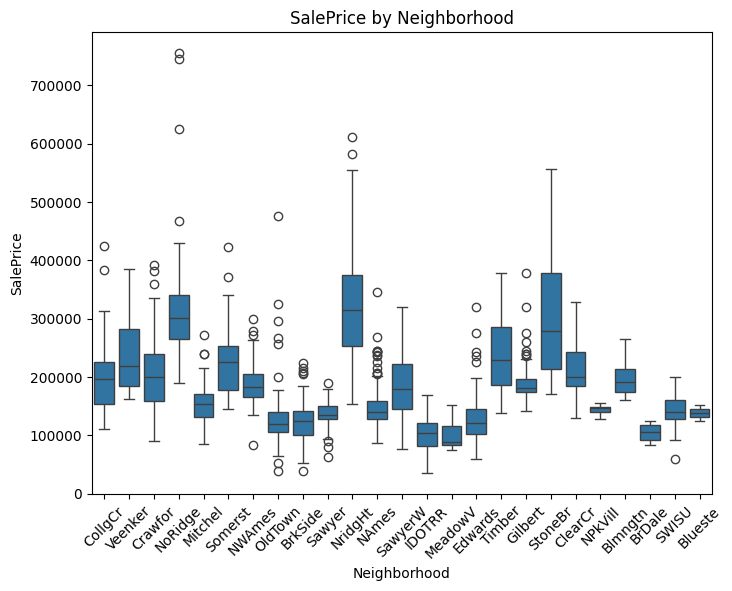

In [13]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Neighborhood', y='SalePrice', data=df)
plt.xticks(rotation=45)
plt.title("SalePrice by Neighborhood")
plt.show()

In [14]:
print("Top 5 Correlations with SalePrice:\n", df.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False).head(6))

Top 5 Correlations with SalePrice:
 SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
Name: SalePrice, dtype: float64


In [15]:
x = df.drop(['Id', 'SalePrice'], axis=1)
y = df['SalePrice']

In [16]:
num_cols = ['LotArea','GrLivArea','TotalBsmtSF','GarageArea','OverallQual']
cat_cols = ['Neighborhood', 'BldgType', 'HouseStyle', 'MSZoning']

In [17]:
preprocessor = ColumnTransformer(
    transformers = [('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
            ]), num_cols),
                   ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_cols)
                   ]
)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [18]:
# apply preprocessing
x_train_pre = preprocessor.fit_transform(x_train)
feature_names = preprocessor.get_feature_names_out()
x_test_pre = preprocessor.fit_transform(x_test)

In [19]:
print("X Train pre shape :", x_train_pre.shape)
print("X Test pre shape :", x_test_pre.shape)

X Train pre shape : (1168, 44)
X Test pre shape : (292, 43)


In [20]:
# Train Model
rf = RandomForestRegressor(random_state=42)
rf.fit(x_train_pre, y_train)

RandomForestRegressor(random_state=42)

In [21]:
# Fix test set shape (if needed)
if x_test_pre.shape[1] != x_train_pre.shape[1]:
    missing_cols = set(feature_names) - set(preprocessor.get_feature_names_out(x_test.columns))
    missing_cols_idx = [list(feature_names).index(col) for col in missing_cols]
    for idx in missing_cols_idx:
        x_test_pre = np.insert(x_test_pre, idx, 0, axis=1)
    print("X_test_pre shape (after fix):", x_test_pre.shape)
else:
    print("X_test_pre shape:", x_test_pre.shape)

X_test_pre shape (after fix): (292, 44)


In [25]:
y_pred = rf.predict(x_test_pre)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Random Forest RMSE: {rmse:.2f}")
print(f"Random Forest R2: {r2:.2f}")

Random Forest RMSE: 29194.74
Random Forest R2: 0.89


In [26]:
# Save model and preprocessor
joblib.dump(rf, 'house_price_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

['preprocessor.pkl']